# Checking if BWS85 can see the blowup of the wire

- BWS85 triggered any turn
- BWS64 triggered once every two turns as blowup source

In [2]:
# Quick fix for the usual Swan problems...
%run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-accuracy-measurement
Your IP is 172.17.0.18
2018-10-02 10:59:41


In [3]:
# %run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

In [137]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.09.24/'

matlabVars = ['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 64
                'PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_64_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples'
             ]

In [138]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 251 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.09.24//data/2018.09.24.11.52.54.576.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.09.24//data/2018.09.24.14.53.47.510.mat


In [139]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [140]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-24 12:53:22.300000'].name) # wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-24 13:12:39.100000'].name) # same
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-24 14:48:45.100000'].name) # nobeam

Dropped 83 duplicate(s)
---
BPM data ok
---


# Check if the wirescanner 64 was swinging or not

In [141]:
myDataFrame['WS64_on'] = False

for k in range(len(myDataFrame)-1):
    thisX = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1'].iloc[k]
    nextX = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1'].iloc[k+1]
    
    if len(thisX) == len(nextX):
        if np.sum(thisX - nextX ) == 0:
            myDataFrame['WS64_on'].iloc[k] = True
            

In [142]:
# myDataFrame[['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1','WS64_on']]

# Save the imported data

In [143]:
myDataFrame.to_pickle('imported_data_2018.09.24.pkl')

In [144]:
# myDataFrame=pnd.read_pickle('imported_data_2018.09.21.pkl')

# Intensity

In [145]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity_max'] = [np.max(x) for x in myDataFrame['Intensity']]
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][85]/np.max(x) )

Text(0,0.5,u'Losses')

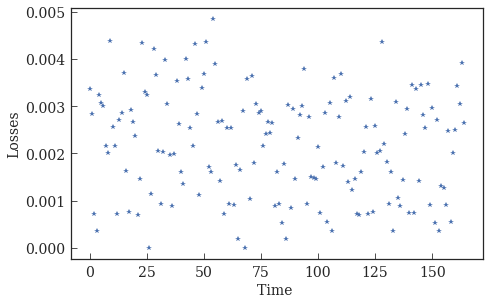

In [146]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

(0, 1000)

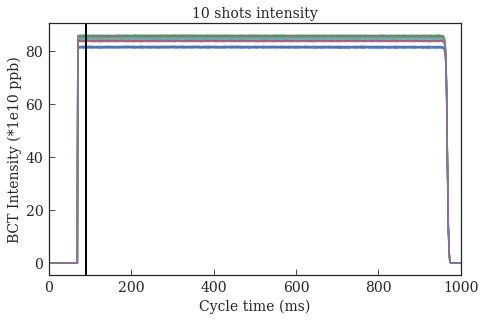

In [147]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=90, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')
plt.xlim(0, 1000)
# plt.ylim(80,82)

# Calculate wire scanner sigma

## BWS 85

In [148]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS85_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS85_sigma_y'] = myDataFrame['WS85_fit_results_y'].apply(lambda x: x[0][-1])
myDataFrame['WS85_mean_y'] = myDataFrame['WS85_fit_results_y'].apply(lambda x: x[0][-2])

## BWS 64

In [149]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS64_position'] = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS64_position_idx'] = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS64_data'] = myDataFrame['BWS64_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS64_data'].iloc[r] = np.interp(pos, myDataFrame['BWS64_position'].iloc[r], myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS64_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS64_fit_results_y'] = myDataFrame['BWS64_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS64_sigma_y'] = myDataFrame['WS64_fit_results_y'].apply(lambda x: x[0][-1])
myDataFrame['WS64_mean_y'] = myDataFrame['WS64_fit_results_y'].apply(lambda x: x[0][-2])

In [150]:
# cleanup the wirescanner acquired without trigger
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.acqTimeInCycleSet1'].loc[myDataFrame['WS64_on']==False] = np.nan
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1'].loc[myDataFrame['WS64_on']==False] = np.nan
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1'].loc[myDataFrame['WS64_on']==False] = np.nan

Using two wirescanners:		 3.39842414858 +/- 0.126208470087
Using a single wirescanners:	 3.39842414858 +/- 0.126208470087
				 ----------------------------------
Difference:			 0.0 %


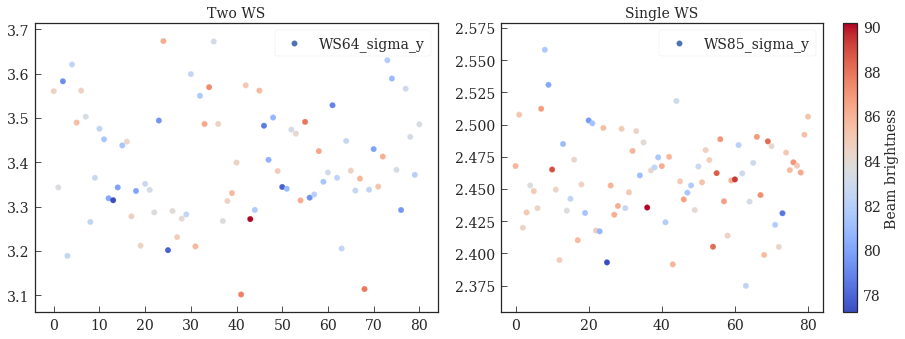

In [151]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

yy = myDataFrame['WS64_sigma_y'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
xx = np.linspace(0, len(yy)-1, len(yy))
cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == False].shift(-1)[:81]
p1 = ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
# clb = fig.colorbar(p1)
# clb.set_label('Beam brightness')
ax[0].legend(frameon=True)
ax[0].set_title('Two WS')
print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

yy2 = myDataFrame['WS85_sigma_y'].loc[(myDataFrame['WS64_on'] == True)]
xx2 = np.linspace(0, len(yy2)-1, len(yy2))
cc2 = myDataFrame['Intensity_max'].loc[(myDataFrame['WS64_on'] == True)].shift(0)[:81]

p2 = ax[1].scatter(xx2, yy2, c = cc2, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p2)
clb.set_label('Beam brightness')
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')
print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*( np.mean(yy1)/np.mean(yy) - 1))+str(' %'))

fig.tight_layout()

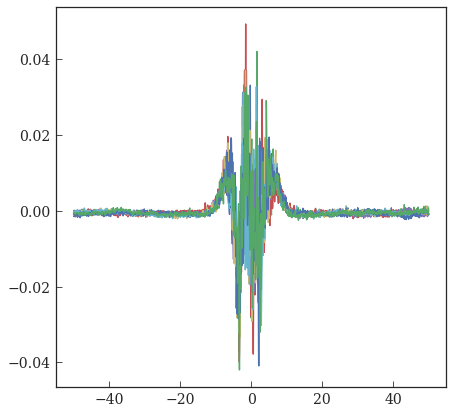

In [152]:
# k=5

fig, ax = plt.subplots(1,figsize=(7,7))
xx = pos

for k in 1+np.array(range(8)):
    yy = myDataFrame['BWS85_data'].iloc[k]

# ax.plot(xx, yy)

# ax.plot(pos, myToolbox.gaussian_5_parameters(pos, *myDataFrame['WS85_fit_results_y'].iloc[k][0]),'r')
    ax.plot(pos, yy-myToolbox.gaussian_5_parameters(pos, *myDataFrame['WS85_fit_results_y'].iloc[k][0]))


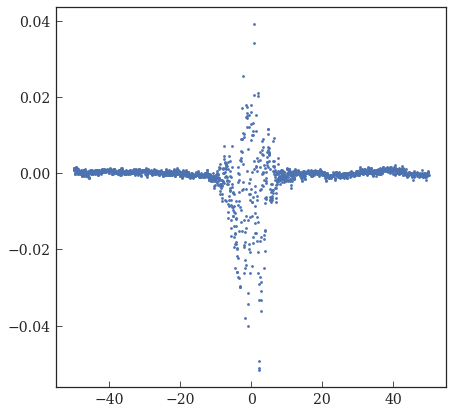

In [153]:
k=40

fig, ax = plt.subplots(1,figsize=(7,7))
xx = pos

yy = myDataFrame['BWS85_data'].iloc[k]
yy2 = myDataFrame['BWS85_data'].iloc[k+1]

ax.plot(xx, yy-yy2,'.')

# ax.plot(pos, myToolbox.gaussian_5_parameters(pos, *myDataFrame['WS85_fit_results_y'].iloc[k][0]),'r')
#     ax.plot(pos, yy-myToolbox.gaussian_5_parameters(pos, *myDataFrame['WS85_fit_results_y'].iloc[k][0]))


Using a single wirescanners:	 2.4412615243 +/- 0.0361265340979
				 ----------------------------------
Difference:			 39.2077053094 %


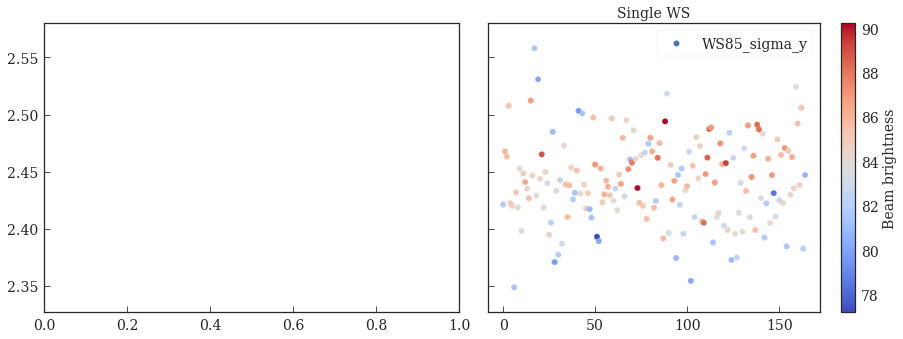

In [154]:
fig, ax = plt.subplots(1,2,figsize=(13,5), sharey=True)

# yy = myDataFrame['WS64_sigma_y'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
# xx = np.linspace(0, len(yy)-1, len(yy))
# cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == True]
# p1 = ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
# # clb = fig.colorbar(p1)
# # clb.set_label('Beam brightness')
# ax[0].legend(frameon=True)
# ax[0].set_title('Two WS')
# print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

yy = myDataFrame['WS85_sigma_y']#.loc[(myDataFrame['WS64_on'] == False)]
xx = np.linspace(0, len(yy)-1, len(yy))
cc = myDataFrame['Intensity_max']#.loc[(myDataFrame['WS64_on'] == False)]

p2 = ax[1].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p2)
clb.set_label('Beam brightness')
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')
print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*( np.mean(yy1)/np.mean(yy) - 1))+str(' %'))

fig.tight_layout()

# Check the sigma with and without scattering

Using two wirescanners:		 2.45729661106 +/- 0.0338904661107
Using a single wirescanners:	 2.42579911922 +/- 0.0311299009468
				 ----------------------------------
Difference:			 1.29843776403 %


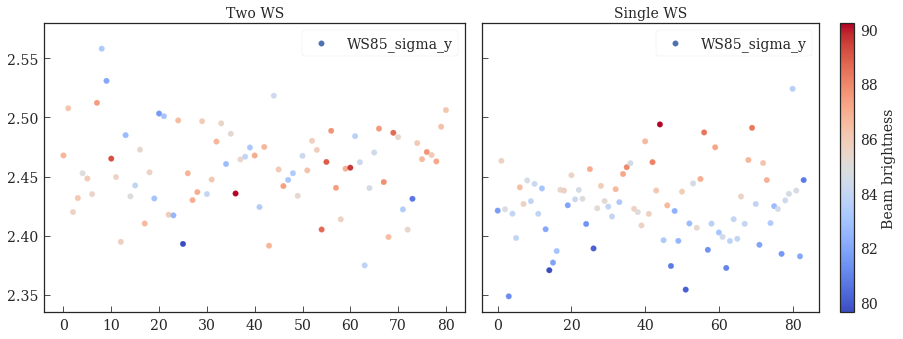

In [155]:
fig, ax = plt.subplots(1,2,figsize=(13,5), sharey=True)

yy = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
xx = np.linspace(0, len(yy)-1, len(yy))
cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == True]
p1 = ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
# clb = fig.colorbar(p1)
# clb.set_label('Beam brightness')
ax[0].legend(frameon=True)
ax[0].set_title('Two WS')
print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

yy = myDataFrame['WS85_sigma_y'].loc[(myDataFrame['WS64_on'] == False)]
xx = np.linspace(0, len(yy)-1, len(yy))
cc = myDataFrame['Intensity_max'].loc[(myDataFrame['WS64_on'] == False)]

p2 = ax[1].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p2)
clb.set_label('Beam brightness')
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')
print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*( np.mean(yy1)/np.mean(yy) - 1))+str(' %'))

fig.tight_layout()

# Same stuff, but with intensity normalisation

- This makes sense for the single wire data ! The others are already remixed by the scattering

(array([  3.37368774e+00,   2.89477902e-04]), array([  1.34343670e-01,   1.88465754e-05]))


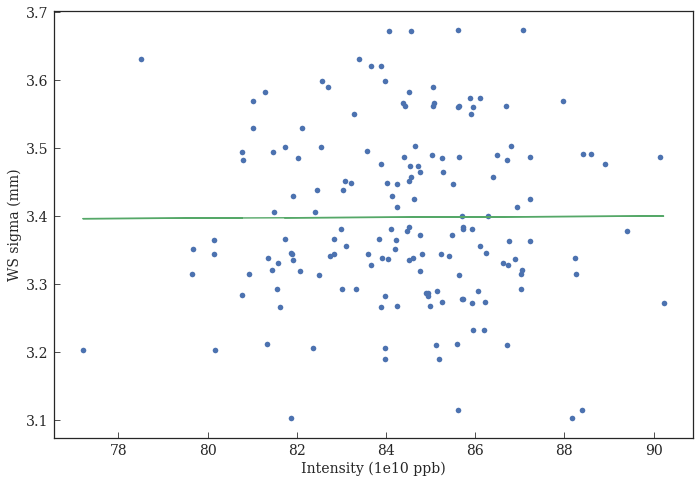

In [156]:
# find correlation parameter for the single wirescanner one 
xx = myDataFrame['Intensity_max']#.loc[myDataFrame['WS64_on']==False]
yy = myDataFrame['WS64_sigma_y']#.loc[myDataFrame['WS64_on']==False]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xx, yy, 'o')
ax.set_xlabel('Intensity (1e10 ppb)')
ax.set_ylabel('WS sigma (mm)')

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [157]:
myDataFrame['WS85_sigma_y_corrected'] = np.nan

(array([ 1.50008508,  0.01097231]), array([  8.32710990e-03,   1.16913204e-06]))


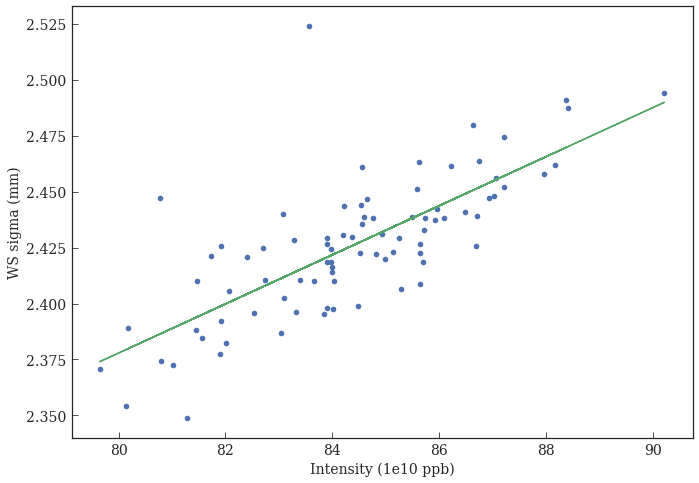

In [158]:
# find correlation parameter for the single wirescanner one 
xx = myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==False]
yy = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==False]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xx, yy, 'o')
ax.set_xlabel('Intensity (1e10 ppb)')
ax.set_ylabel('WS sigma (mm)')

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [159]:
# using manual scaling
def scale_sigma(intensity, sigma):
    '''
    Scale the sigma due to the Intensity of 85e10 ppb
    '''
    a = 1.50008508
    b = 0.01097231
    
    corr_factor = lin(intensity, a, b) / lin(85, a, b)
    return sigma/corr_factor

myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on']==False] = scale_sigma(myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==False], myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==False])



(array([  2.45428671e+00,   3.56492104e-05]), array([  1.78308832e-02,   2.49931877e-06]))


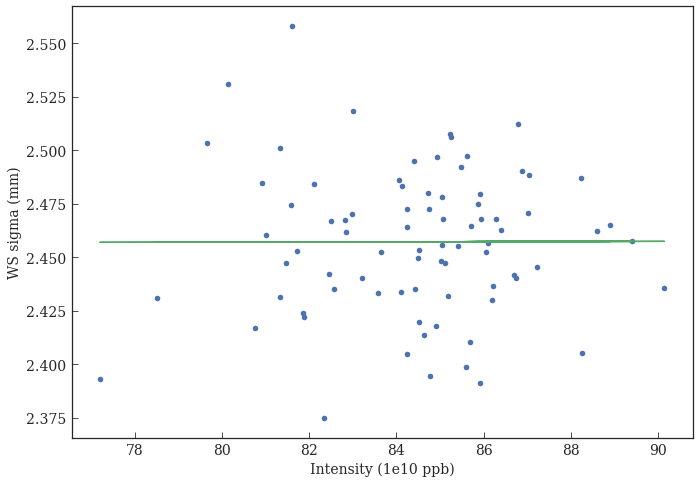

In [160]:
# find correlation parameter for the double wirescanner ones --> I expect none
xx = myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==True]
yy = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==True]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xx, yy, 'o')
ax.set_xlabel('Intensity (1e10 ppb)')
ax.set_ylabel('WS sigma (mm)')

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [161]:
# since is not needed, just copy
myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on']==True] = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==True]


Using two wirescanners:		 2.45729661106 +/- 0.0338904661107
Using a single wirescanners:	 2.43273165769 +/- 0.0208646974709
				 ----------------------------------
Difference:			 1.00976831097 %


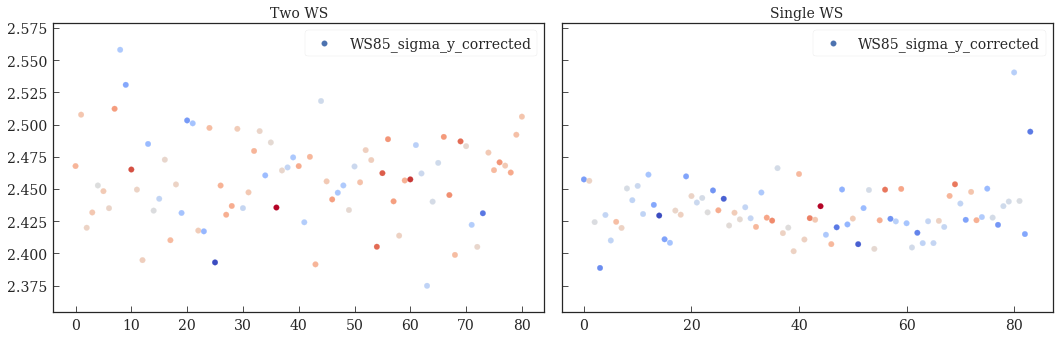

In [162]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)

yy = myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
xx = np.linspace(0, len(yy)-1, len(yy))
cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == True]
ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
ax[0].legend(frameon=True)
ax[0].set_title('Two WS')
print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

yy = myDataFrame['WS85_sigma_y_corrected'].loc[(myDataFrame['WS64_on'] == False) & (myDataFrame['WS85_sigma_y']<3)]
xx = np.linspace(0, len(yy)-1, len(yy))
cc = myDataFrame['Intensity_max'].loc[(myDataFrame['WS64_on'] == False) & (myDataFrame['WS85_sigma_y']<3)]

ax[1].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')
print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*( np.mean(yy1)/np.mean(yy) - 1))+str(' %'))

fig.tight_layout()

In [163]:
# last check: the bump in the signal given by the scattering

# Conclusions

- As usual there is a correlation between the intensity and the sigma coming from the booster phase space painting
- The wire scan remixes the angular distribution, determining the loss of the correlation
- The scattering is visible, but at best at the percentage level, not the 3% expected from simulations

In [164]:
myDataFrame.iloc[:10]

,cycleStamp,matlabPLS,matlabFilePath,PR_BPM.AcquisitionTrajectoryBBB.value.position,PR_BWS_64_V_ROT.Acquisition.value.projDataSet1,PR_BWS_64_V_ROT.Acquisition.value.acqTimeInCycleSet1,PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1,PR_BCT_ST.Samples.value.samples,PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1,PR_BPM.AcquisitionOrbit.value.position,...,WS85_fit_results_y,WS85_sigma_y,WS85_mean_y,BWS64_position,BWS64_position_idx,BWS64_data,WS64_fit_results_y,WS64_sigma_y,WS64_mean_y,WS85_sigma_y_corrected
2018-09-24 11:52:07.900,1.537790e+18,CPS.USER.MD3,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,"[[33, 27, 28, 26, 19, 23, 24, 22, 26, 32, 28, ...",NaN,NaN,"[-49963, -49852, -49668, -49595, -49450, -4930...","[-0.02638, -0.01411, -0.00061, 0.01411, 0.0171...",505,"[[0, 28, 35, 31, 27, 25, 25, 25, 24, 25, 24, 2...",...,"([0.145789857953, -1.39776596226e-05, 3.341128...",2.421189,-2.842171e-12,"[-49.987, -49.937, -49.873, -49.81, -49.747, -...","[1286, 1285, 1284, 1283, 1282, 1281, 1280, 127...","[0.171895003602, 0.171747093555, 0.17204219305...","([0.173315103761, -7.94272089929e-05, 3.614006...",3.365851,1.393314,2.457467
2018-09-24 11:53:34.300,1.537790e+18,CPS.USER.MD3,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,"[[28, 20, 20, 20, 20, 27, 23, 19, 24, 24, 22, ...","[0.172295458822, 0.171895003602, 0.17189500360...",500.0,"[-49963, -49852, -49741, -49558, -49450, -4927...","[-0.09262, -0.06931, -0.05459, -0.03128, -0.02...",505,"[[0, 27, 34, 29, 27, 25, 25, 24, 24, 24, 25, 2...",...,"([0.145786930894, -2.67194781334e-06, 3.464427...",2.467831,-3.332197e-01,"[-49.987, -49.949, -49.899, -49.835, -49.759, ...","[1288, 1287, 1286, 1285, 1284, 1283, 1282, 128...","[0.169314635339, 0.169506555509, 0.16970513247...","([0.174487343547, -1.66502509127e-05, 3.692115...",3.560678,1.049302,2.467831
2018-09-24 11:54:17.500,1.537790e+18,CPS.USER.MD3,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,"[[34, 27, 18, 22, 27, 29, 26, 17, 26, 26, 26, ...",NaN,NaN,"[-49926, -49778, -49704, -49595, -49378, -4930...","[-0.06686, -0.0552, -0.0503, -0.0368, -0.02208...",505,"[[0, 27, 34, 30, 27, 26, 25, 25, 25, 24, 24, 2...",...,"([0.145753726095, -3.44304425953e-06, 3.472684...",2.463284,-3.165828e-01,"[-49.987, -49.949, -49.899, -49.835, -49.759, ...","[1288, 1287, 1286, 1285, 1284, 1283, 1282, 128...","[0.169314635339, 0.169506555509, 0.16970513247...","([0.174487343547, -1.66502509127e-05, 3.692115...",3.560678,1.049302,2.456381
2018-09-24 11:55:43.900,1.537790e+18,CPS.USER.MD3,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,"[[29, 26, 24, 27, 29, 27, 23, 25, 33, 26, 23, ...","[0.178415463946, 0.179456394258, 0.17883110955...",500.0,"[-50000, -49889, -49704, -49595, -49486, -4937...","[-0.04416, -0.03006, -0.02024, -0.00429, 0.017...",505,"[[0, 26, 34, 30, 26, 25, 25, 24, 24, 24, 24, 2...",...,"([0.145707183563, 1.14131132321e-06, 3.6081647...",2.507719,-3.180950e-01,"[-50.0, -49.962, -49.911, -49.861, -49.772, -4...","[1289, 1288, 1287, 1286, 1285, 1284, 1283, 128...","[0.171895003602, 0.170454077073, 0.17065282633...","([0.176575452995, -2.48183798631e-05, 3.602207...",3.343549,1.282663,2.507719
2018-09-24 11:56:27.100,1.537790e+18,CPS.USER.MD3,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,"[[33, 32, 22, 25, 25, 27, 26, 20, 26, 26, 25, ...",NaN,NaN,"[-49975, -49889, -49704, -49668, -49522, -4937...","[-0.1098, -0.09507, -0.08097, -0.05643, -0.039...",505,"[[0, 27, 34, 29, 27, 26, 25, 25, 25, 24, 24, 2...",...,"([0.145777244207, -9.90152562658e-07, 3.452753...",2.422289,-3.214328e-01,"[-50.0, -49.962, -49.911, -49.861, -49.772, -4...","[1289, 1288, 1287, 1286, 1285, 1284, 1283, 128...","[0.171895003602, 0.170454077073, 0.17065282633...","([0.176575452995, -2.48183798631e-05, 3.602207...",3.343549,1.282663,2.424331
2018-09-24 11:57:53.500,1.537790e+18,CPS.USER.MD3,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,"[[29, 23, 22, 23, 22, 34, 27, 29, 26, 31, 27, ...","[0.167746006402, 0.168528495821, 0.16696715013...",500.0,"